# Exploratory Data Analysis – Part 1: Univariate Analysis

### Description
- This notebook performs univariate analysis on the merged clinical trials dataset.
- It explores the target distribution, numerical variables (raw + log transforms), and
  categorical variables relevant to trial design.

### Workflow
1) Load dataset and run basic checks (shape, nulls, duplicates)
2) Target variable distribution
3) Numerical variables:
   - Boxplots
   - Enrollment: raw vs. log(1+x)
   - Duration of study: raw vs. log(1+x)
   - Correlation heatmap ('Spearman`)
4) Categorical variables:
   phase, intervention, condition, allocation, model, purpose, masking, sponsor, eligibility

### Outputs
- Tables/plots under: `../results/EDA1_outputs/`
- Final processed dataset → `../data/processed/df_EDA_1.csv`

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
DATA_PROCESSED = Path("../data/processed")
RESULTS_DIR = Path("../results/EDA1_outputs")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Utility: safe save figure
def savefig(path, tight=True, dpi=200, show=True):
    if tight:
        plt.tight_layout()
    plt.savefig(RESULTS_DIR / path, dpi=dpi)
    if show:
        plt.show()
    plt.close()

In [2]:
# Load dataset
df_EDA_1 = pd.read_csv(DATA_PROCESSED / "df_merged.csv")

print("✅ Loaded dataset")
print("Shape:", df_EDA_1.shape)
print("Duplicate rows:", df_EDA_1.duplicated().sum())

# Missing values summary
print("\nMissing values (top 10):")
print(df_EDA_1.isna().sum().sort_values(ascending=False).head(10))


# Drop unused column
df_EDA_1.drop(columns = ['study_type'], inplace= True)

✅ Loaded dataset
Shape: (263165, 80)
Duplicate rows: 0

Missing values (top 10):
nct_id                     0
study_type                 0
purpose_supportive_care    0
purpose_research           0
purpose_prevention         0
purpose_other              0
purpose_diagnostic         0
model_unknown              0
model_single_group         0
model_sequential           0
dtype: int64


Target Class Distribution:


,count,percent
overall_status,,
1,225047,85.52
0,38118,14.48


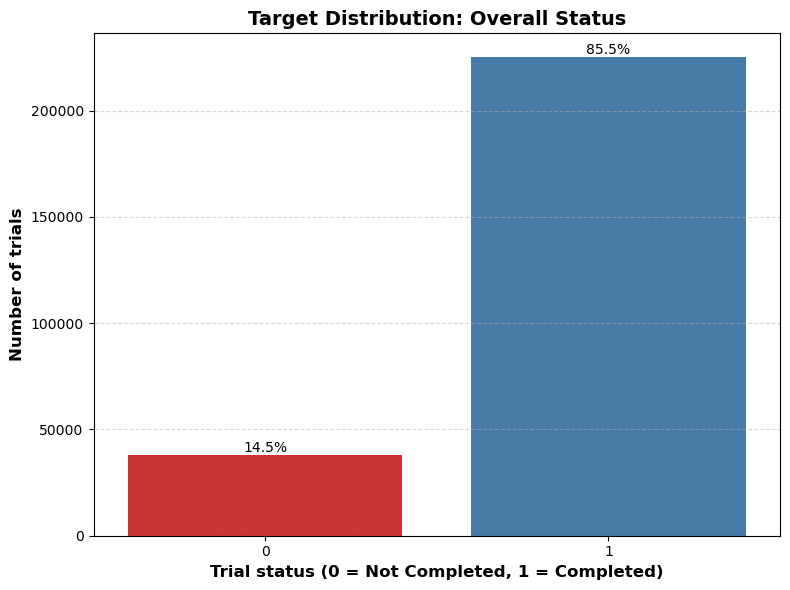

In [3]:
# Target distribution (table + plot)
print("Target Class Distribution:")
counts = df_EDA_1['overall_status'].value_counts(dropna=False)
perc = df_EDA_1['overall_status'].value_counts(normalize=True, dropna=False) * 100
target_table = pd.DataFrame({"count": counts, "percent": perc.round(2)})
display(target_table)

# Save table
target_table.to_csv(RESULTS_DIR / "target_distribution.csv")

# Plot
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = 'overall_status', hue = 'overall_status', data = df_EDA_1, palette = 'Set1', legend = False)
plt.title('Target Distribution: Overall Status', fontsize = 14, fontweight = 'bold')
plt.xlabel('Trial status (0 = Not Completed, 1 = Completed)', fontsize = 12, fontweight = 'bold')
plt.ylabel('Number of trials', fontsize = 12, fontweight = 'bold')

# Add percentage labels on bars
total = len(df_EDA_1)
for p in ax.patches:
    count = p.get_height()
    percentage = count / total * 100
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width()/2, count),
                ha = 'center', va = 'bottom', fontsize = 10)
    
plt.grid(True, axis = 'y', linestyle="--", alpha = 0.5)
savefig("target_distribution.png")

In [4]:
# Numerical columns
df_EDA_1[['enrollment', 'duration_of_study', 'number_of_arms', 'intervention_count']].describe()

,enrollment,duration_of_study,number_of_arms,intervention_count
count,2.631650e+05,263165.000000,263165.000000,263165.000000
mean,6.102213e+02,906.955218,2.180849,1.150286
std,4.854230e+04,876.527882,1.353645,0.416967
min,0.000000e+00,-17.000000,1.000000,1.000000
25%,2.300000e+01,304.000000,2.000000,1.000000
50%,5.100000e+01,668.000000,2.000000,1.000000
75%,1.280000e+02,1246.000000,2.000000,1.000000
max,2.012121e+07,38562.000000,44.000000,6.000000


In [5]:
df_EDA_1 = df_EDA_1[df_EDA_1['duration_of_study'] >= 0]

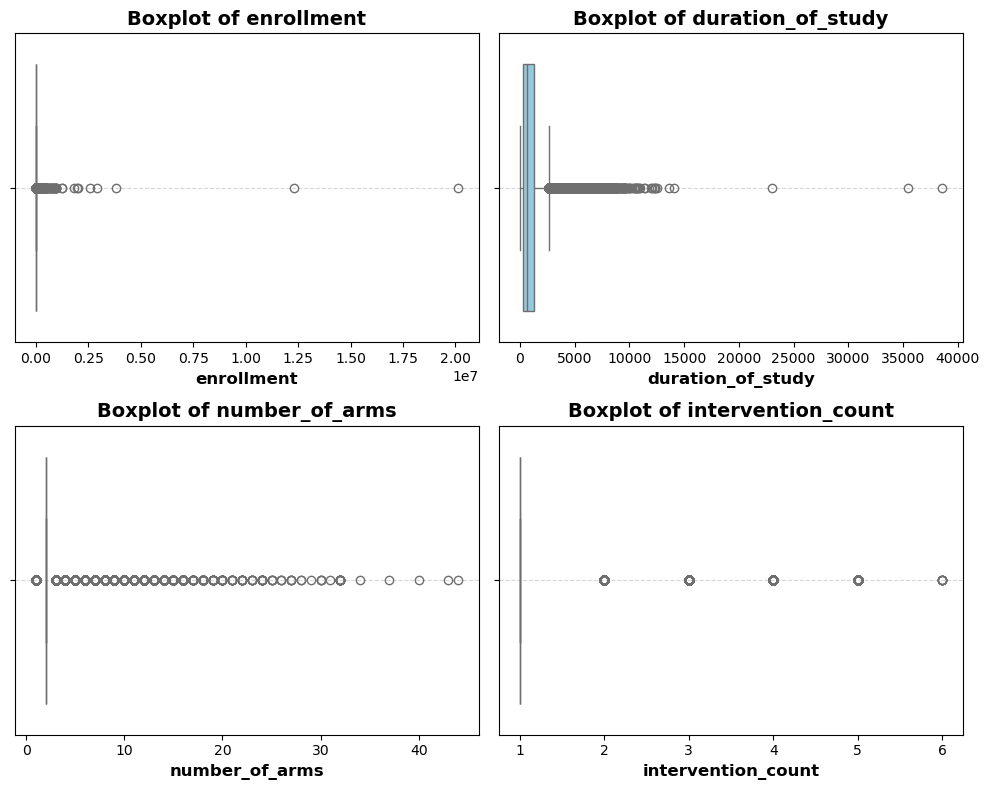

In [6]:
# Boxplot for numerical columns
numerical_cols = ['enrollment', 'duration_of_study', 'number_of_arms', 'intervention_count']

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x = df_EDA_1[col], color= 'skyblue', ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}", fontsize = 14, fontweight = 'bold')
    axes[i].set_xlabel(col, fontsize = 12, fontweight = 'bold')
    axes[i].grid(True, axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
savefig('boxplot_num_cols.png')

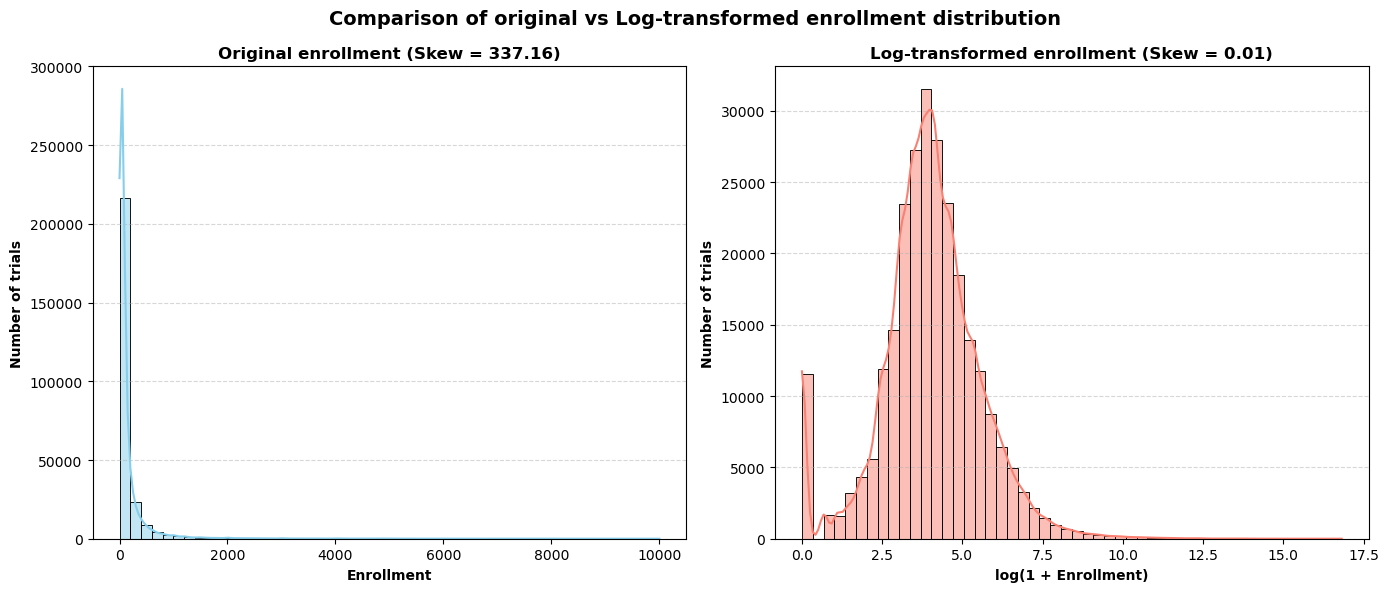

In [7]:
# Distribution of enrollment: original vs log-transformed 
# Apply log(1 + x) transformation to reduce skewness and handle zero values

df_EDA_1['log_enrollment'] = np.log1p(df_EDA_1['enrollment'])

# Plot original enrollment up to 10000 to keep histogram legible 
subset = df_EDA_1[df_EDA_1['enrollment'] < 10000] 

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw Enrollment
sns.histplot(data = subset, x ='enrollment', kde = True, bins = 50, color = 'skyblue', edgecolor = 'black', ax = axes[0])
axes[0].set_title(f"Original enrollment (Skew = {df_EDA_1['enrollment'].skew():.2f})", fontsize=12, fontweight='bold')
axes[0].set_xlabel('Enrollment', fontsize = 10, fontweight = 'bold')
axes[0].set_ylabel('Number of trials', fontsize = 10, fontweight = 'bold')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Log Enrollment
sns.histplot(data= df_EDA_1, x='log_enrollment',  kde = True, bins = 50, color = 'salmon', edgecolor = 'black', ax = axes[1])
axes[1].set_title(f"Log-transformed enrollment (Skew = {df_EDA_1['log_enrollment'].skew():.2f})", fontsize =12, fontweight ='bold')
axes[1].set_xlabel('log(1 + Enrollment)', fontsize =10, fontweight = 'bold')
axes[1].set_ylabel('Number of trials', fontsize =10, fontweight = 'bold')
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Comparison of original vs Log-transformed enrollment distribution', fontsize=14, fontweight='bold')
savefig('enroll_dist_original_vs_log.png')

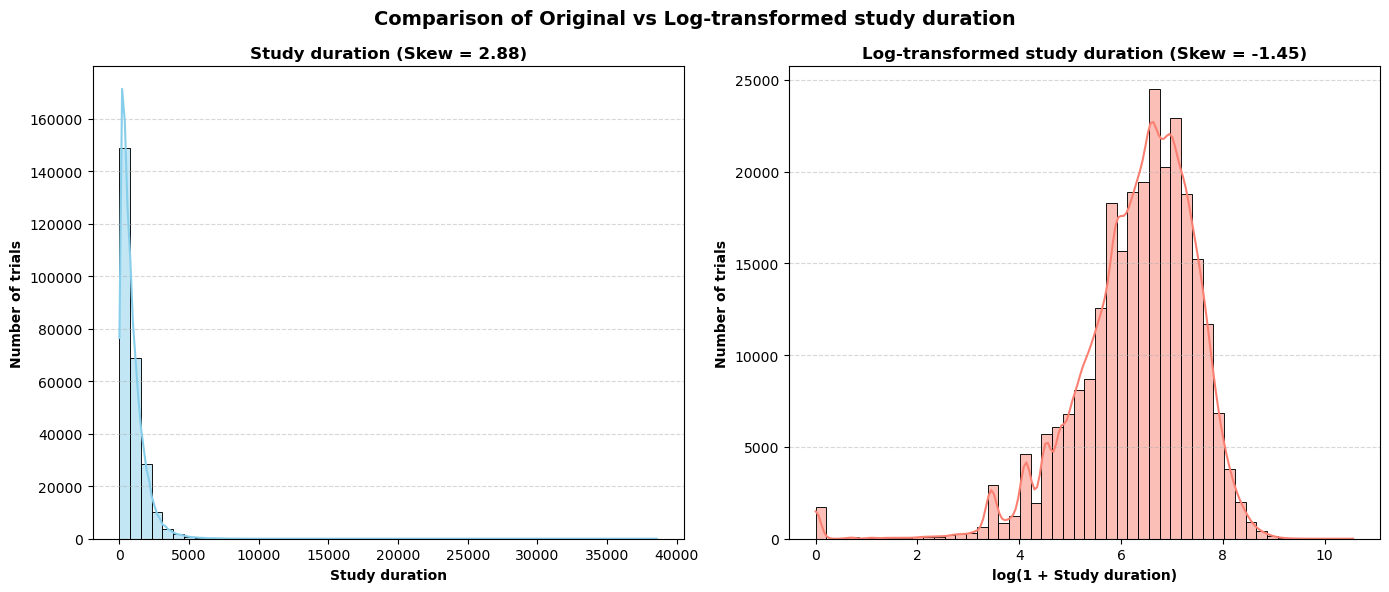

[SAVED] Comparison of original vs Log-transformed study duration


In [8]:
# study duration distributions : original vs log-transformed 
# Apply log(1 + x) transformation to reduce skewness and handle zero values
df_EDA_1['log_duration'] = np.log1p(df_EDA_1['duration_of_study'])

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot original duration
sns.histplot(df_EDA_1['duration_of_study'], kde = True, bins=50, color='skyblue',  edgecolor = 'black', ax=axes[0])
axes[0].set_title(f"Study duration (Skew = {df_EDA_1['duration_of_study'].skew():.2f})", fontsize=12, fontweight='bold')
axes[0].set_xlabel('Study duration', fontsize=10, fontweight = 'bold')
axes[0].set_ylabel('Number of trials', fontsize=10, fontweight = 'bold')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Plot log-transformed duration of study
sns.histplot(df_EDA_1['log_duration'], kde = True, bins=50, color='salmon',  edgecolor = 'black', ax=axes[1])
axes[1].set_title(f"Log-transformed study duration (Skew = {df_EDA_1['log_duration'].skew():.2f})", fontsize=12, fontweight='bold')
axes[1].set_xlabel('log(1 + Study duration)', fontsize=10, fontweight = 'bold')
axes[1].set_ylabel('Number of trials', fontsize=10, fontweight = 'bold')
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

# Super title
plt.suptitle('Comparison of Original vs Log-transformed study duration', fontsize=14, fontweight='bold')
savefig('duration_dist_original_vs_log.png')
print("[SAVED] Comparison of original vs Log-transformed study duration")

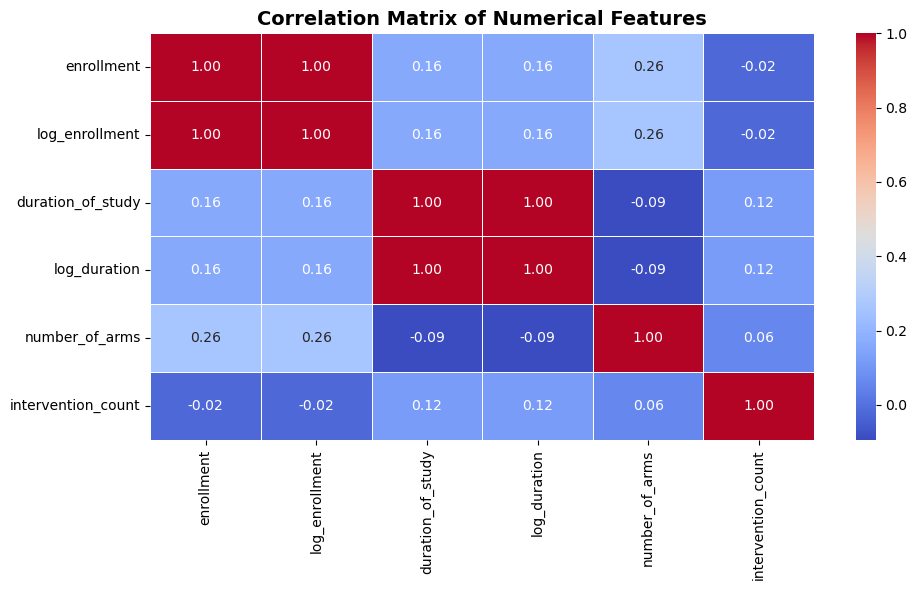

In [9]:
# Correlation Heatmap (numerical features)
numeric_cols = ['enrollment', 'log_enrollment','duration_of_study', 'log_duration', 'number_of_arms', 'intervention_count']

# Compute correlation among num features using Spearman (robust to skewness)
corr_matrix = df_EDA_1[numeric_cols].corr(method = 'spearman')

# Plot
plt.figure(figsize = (10, 6))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', linewidths = 0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize = 14, fontweight = 'bold')
savefig("num_cols_correlation_heatmap.png")

In [10]:
# Function to plot categorical variables starting with a given prefix and print frequency tables
def plot_categorical_variables(df, prefix, exclude = None, title = None, palette = 'Set2', rotate_ticks = False):
    
    cols = [c for c in df.columns if c.startswith(prefix)]
    if exclude:
        cols = [c for c in cols if c not in exclude]
    
    counts = df[cols].apply(pd.to_numeric, errors = 'coerce').sum().sort_values(ascending = False).reset_index()
    counts.columns = ['category', 'count']
    counts['category'] = counts['category'].str.replace(prefix, '', regex = False).str.title()
    
    total = len(df)
    counts['percentage'] = (counts['count'] / total * 100).round(2)
    
    print(f"\nFrequency table for {prefix.replace('_', '')}:")
    display(counts)

    counts.to_csv(RESULTS_DIR / f"{prefix.replace('_', '')}_counts.csv")
    
    plt.figure(figsize = (10, 6))
    ax = sns.barplot(data = counts, x = 'category', y = 'count', hue = 'category', palette = palette, legend = False)
    if rotate_ticks:
        plt.xticks(rotation = 45, ha = 'right')
    plt.title(title, fontsize = 14, fontweight = 'bold')
    plt.xlabel(prefix.replace('_', '').title(), fontsize = 12, fontweight = 'bold')
    plt.ylabel('Number of trials', fontsize = 12, fontweight = 'bold')
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)

    for p in ax.patches:
        count = p.get_height()
        percentage = count / total * 100
        ax.annotate(f'{percentage:.1f}%',
                    (p.get_x() + p.get_width()/2, count),
                    ha = 'center', va = 'bottom', fontsize = 10)
    savefig(f"{prefix.replace('_', '').title()}_dist.png")


Frequency table for phase:


,category,count,percentage
0,Not Applicable,123524,46.94
1,2,44866,17.05
2,1,42505,16.15
3,3,29130,11.07
4,4,23111,8.78


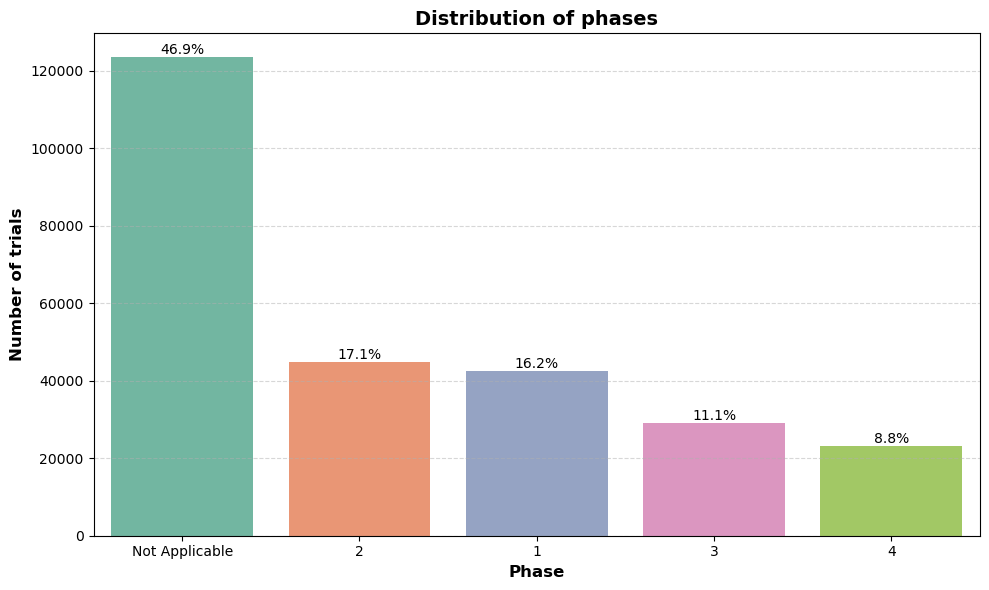

In [11]:
plot_categorical_variables(df_EDA_1, prefix = 'phase_', title = 'Distribution of phases')


Frequency table for intervention:


,category,count,percentage
0,Drug,124124,47.17
1,Other,50655,19.25
2,Device,34418,13.08
3,Behavioral,33360,12.68
4,Procedure,23920,9.09
5,Biological,16519,6.28
6,Dietary_Supplement,10865,4.13
7,Radiation,4222,1.60
8,Diagnostic_Test,2736,1.04
9,Combination_Product,1154,0.44


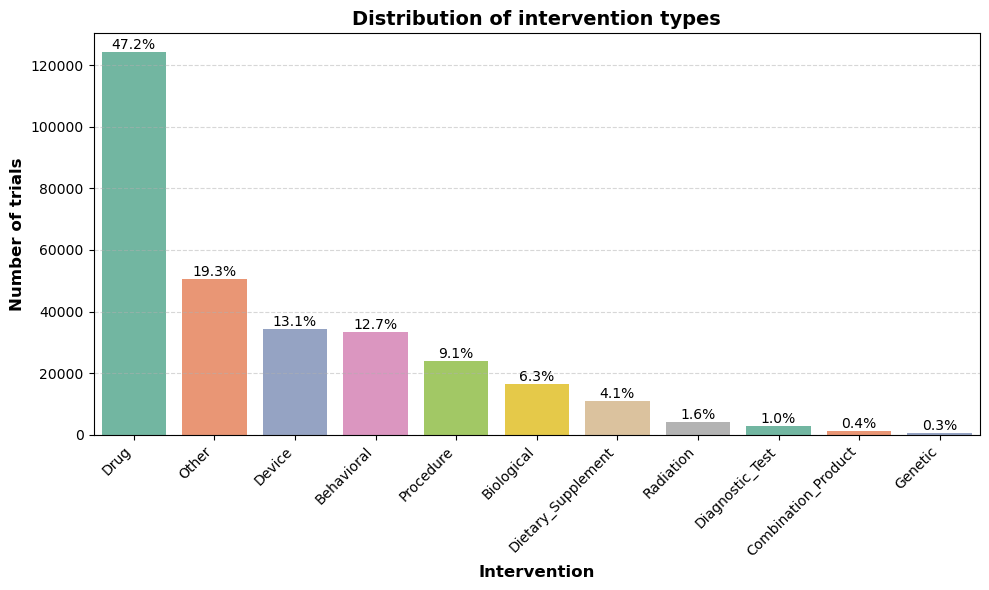

In [12]:
plot_categorical_variables(df_EDA_1, prefix = 'intervention_', exclude = ['intervention_count'], title = 'Distribution of intervention types', rotate_ticks = True)


Frequency table for condt:


,category,count,percentage
0,Others,98171,37.31
1,Cancers,44273,16.83
2,Cardiovascular_Diseases,21051,8.00
3,Endocrine/Metabolic_Disorders,19280,7.33
4,Mental_Disorders,19031,7.23
5,Neurological_Disorders,18628,7.08
6,Infectious_Diseases,16301,6.19
7,Musculoskeletal_Disorders,11749,4.46
8,Respiratory_Disorders,11434,4.35
9,Gastrointestinal_Disorders,11430,4.34


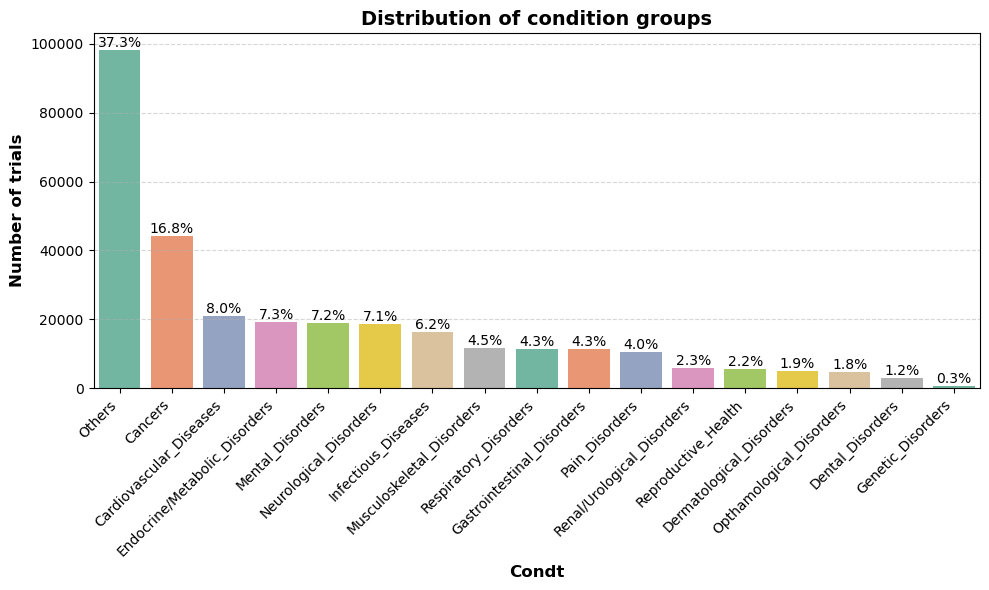

In [13]:
plot_categorical_variables(df_EDA_1, prefix = 'condt_', title = 'Distribution of condition groups', rotate_ticks = True)


Frequency table for allocation:


,category,count,percentage
0,Randomized,170657.0,64.86
1,Non_Randomized,82909.0,31.51
2,Unknown,3779.0,1.44


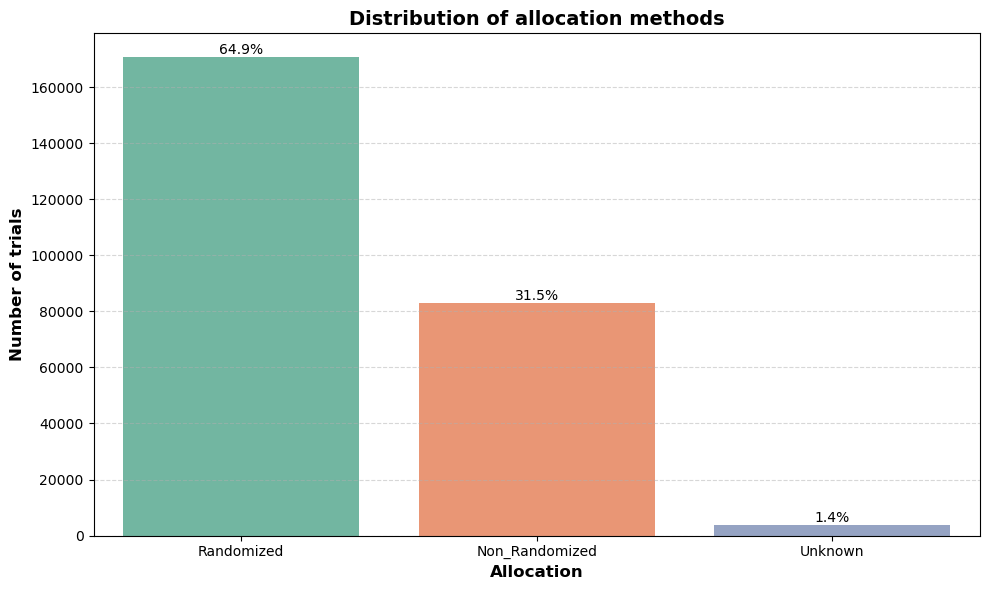

In [14]:
plot_categorical_variables(df_EDA_1, prefix = 'allocation_', title = 'Distribution of allocation methods')


Frequency table for model:


,category,count,percentage
0,Parallel,154316.0,58.64
1,Single_Group,65028.0,24.71
2,Crossover,25095.0,9.54
3,Sequential,5809.0,2.21
4,Factorial,3830.0,1.46
5,Unknown,3267.0,1.24


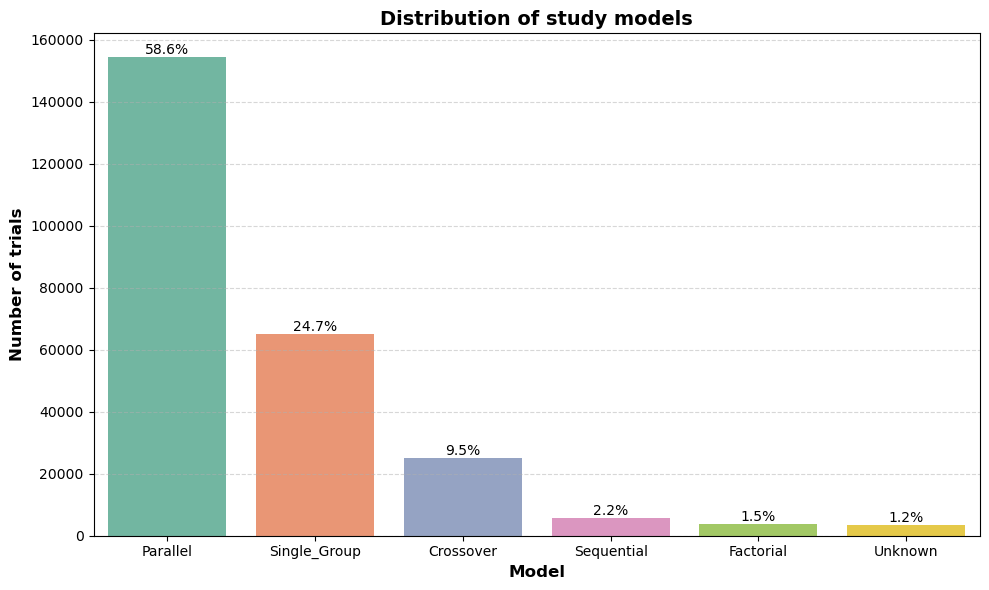

In [15]:
plot_categorical_variables(df_EDA_1, prefix = 'model_', title = 'Distribution of study models')


Frequency table for purpose:


,category,count,percentage
0,Treatment,160944.0,61.16
1,Prevention,28385.0,10.79
2,Research,21528.0,8.18
3,Other,20057.0,7.62
4,Supportive_Care,13773.0,5.23
5,Diagnostic,12658.0,4.81


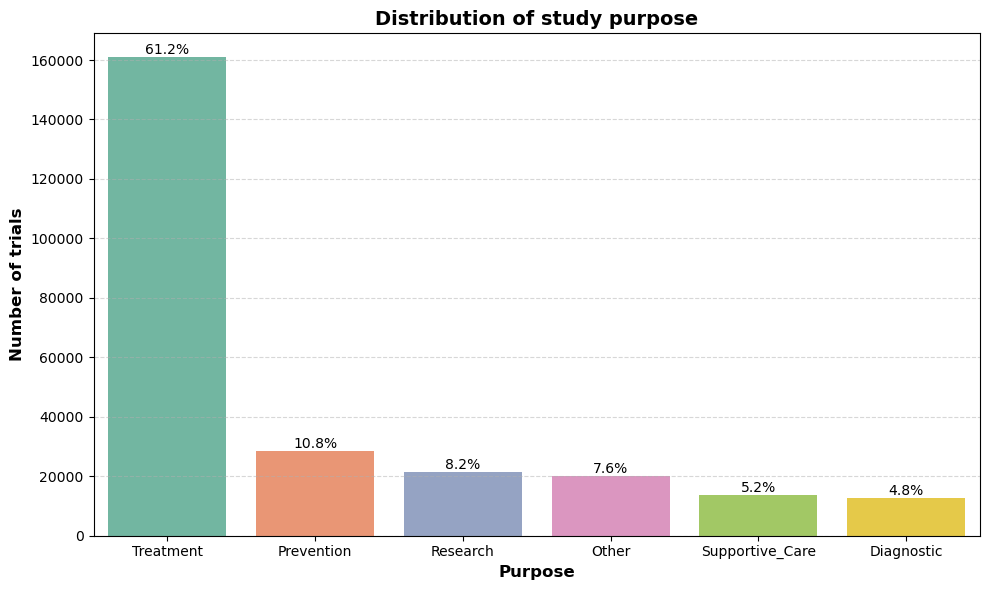

In [16]:
plot_categorical_variables(df_EDA_1, prefix = 'purpose_', title = 'Distribution of study purpose')


Frequency table for masking:


,category,count,percentage
0,Unknown,140749.0,53.49
1,Double,36557.0,13.89
2,Single,36472.0,13.86
3,Quadruple,25583.0,9.72
4,Triple,17984.0,6.83


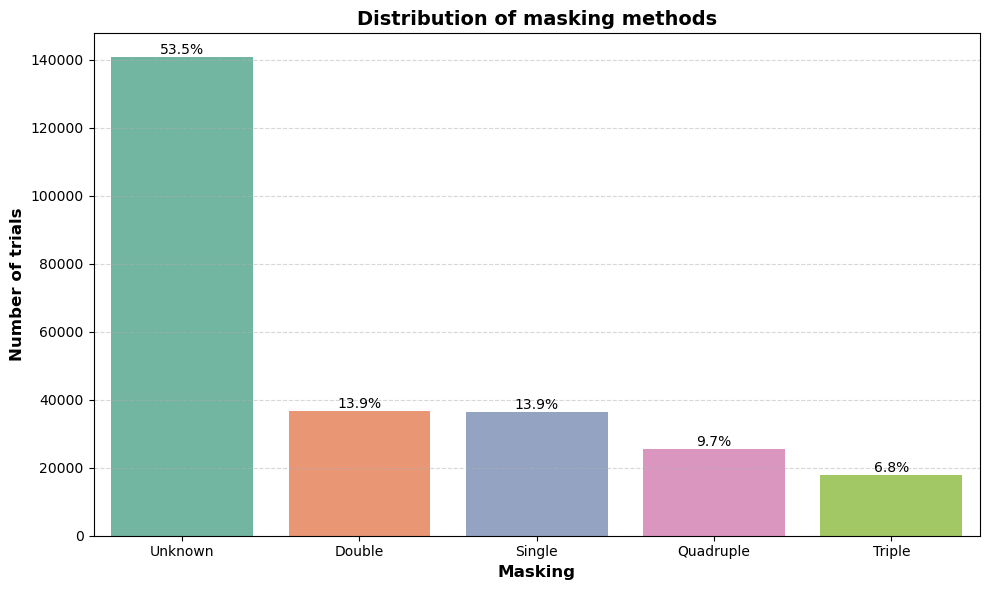

In [17]:
plot_categorical_variables(df_EDA_1, prefix = 'masking_', title = 'Distribution of masking methods')


Frequency table for sponsor:


,category,count,percentage
0,Other,177688,67.53
1,Industry,98329,37.37
2,Government,38566,14.66
3,Unknown,11128,4.23


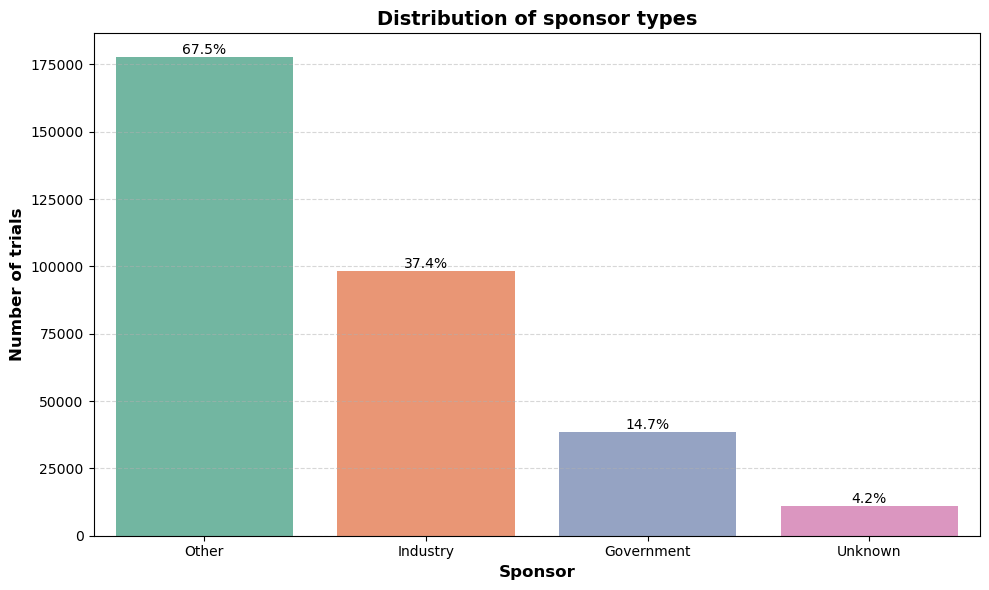

In [18]:
plot_categorical_variables(df_EDA_1, prefix = 'sponsor_', title = 'Distribution of sponsor types')


Frequency table for role:


,category,count,percentage
0,Lead,263136,100.00
1,Collaborator,89189,33.89


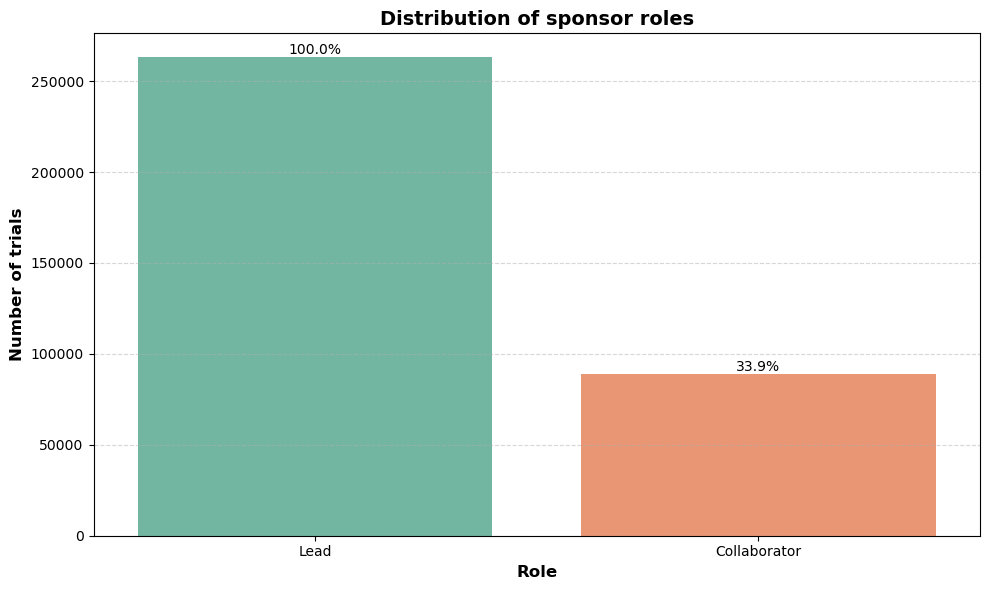

In [19]:
plot_categorical_variables(df_EDA_1, prefix = 'role_', title = 'Distribution of sponsor roles')


Frequency table for elig:


,category,count,percentage
0,Gender_All,224391,85.28
1,Age_Adult,164573,62.54
2,Age_Mixed,71508,27.18
3,Gender_Female,25270,9.60
4,Age_Child,16812,6.39
5,Gender_Male,13475,5.12
6,Age_Unknown,8840,3.36
7,Age_Senior,1403,0.53


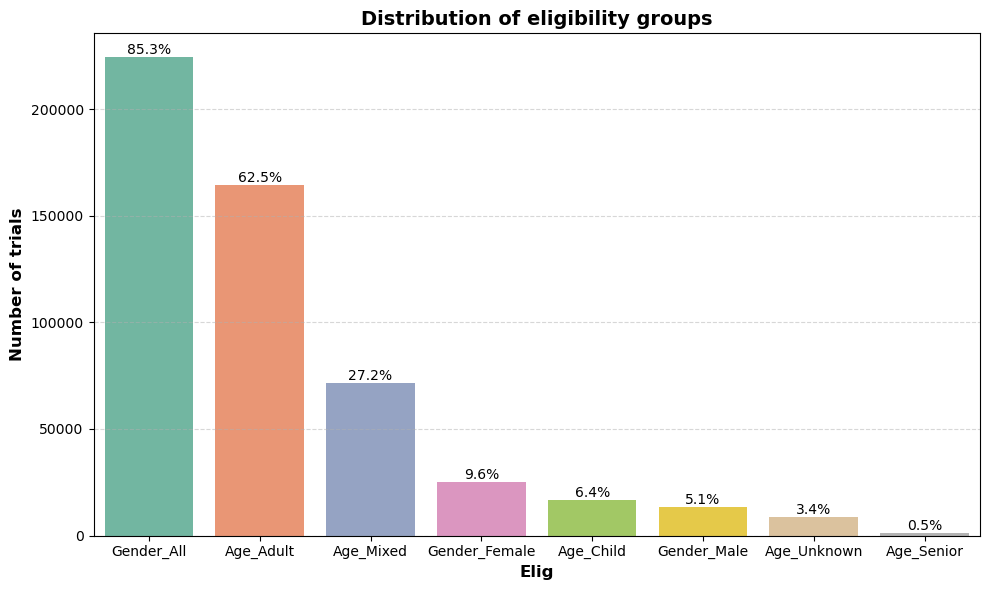

In [20]:
plot_categorical_variables(df_EDA_1, prefix = 'elig_', title = 'Distribution of eligibility groups')

In [21]:
# Export dataset for EDA Part 2
df_EDA_1.to_csv(DATA_PROCESSED / "df_EDA_1.csv", index=False)
print("✅ Saved processed dataset for EDA_2: df_EDA_1.csv")

✅ Saved processed dataset for EDA_2: df_EDA_1.csv


---
### Summary — Univariate Analysis (EDA_1)

#### Target Variable
- **Overall Status:** The dataset is imbalanced — ~85% of trials are *Completed* while ~15% are *Terminated/Other*.  
  This imbalance will be addressed during model evaluation through threshold tuning and balanced metrics.

---

#### Numerical Variables

| Feature | Observation | Transformation & Insights |
|----------|--------------|----------------------------|
| **Enrollment** | Extremely right-skewed (Skew ≈ 337), with very large multi-thousand participant outliers. | Log(1 + x) normalization (Skew ≈ 0.01) yields a nearly Gaussian shape, ideal for modeling. |
| **Duration of Study** | Right-skewed (Skew ≈ 2.9), indicating a few very long trials. | Log transformation (Skew ≈ -1.4) improves symmetry and interpretability. |
| **Number of Arms** | Most studies have 1–2 arms; ≥10 arms rare. | Represents standard two-arm or parallel setups; outliers correspond to platform/adaptive designs. |
| **Intervention Count** | 1–2 interventions typical; higher counts rare. | Indicates focused intervention strategies. |
| **Correlation Insights** | Enrollment moderately correlated with arms (r ≈ 0.26) and duration (r ≈ 0.16). | No high multicollinearity → numeric features safe for inclusion. |

**Summary:**  
Log transformations effectively reduce skewness and improve distribution shape.  
Numeric variables show independence and stability for modeling.

---

#### Categorical Variables

| Feature | Dominant Patterns | Insights |
|----------|------------------|-----------|
| **Phase** | *Not Applicable* (46.9%) largest; Phases 2 (17.1%), 1 (16.2%), 3 (11.1%), 4 (8.8%). | Indicates many exploratory/behavioral studies not phase-based. |
| **Intervention Type** | *Drug* (47%) dominates; *Other* (19%), *Device* (13%), *Behavioral* (13%) also notable. | Reflects a drug-heavy dataset with moderate device/behavioral studies. |
| **Condition Group** | *Others* (37%) and *Cancers* (17%) dominate; others 2–8% each. | Cancer research is highly represented, followed by chronic and mental disorders. |
| **Allocation** | *Randomized* (65%), *Non-Randomized* (31%), *Unknown* (1%). | Majority are randomized controlled trials. |
| **Study Model** | *Parallel* (59%), *Single Group* (25%), *Crossover* (9%). | Parallel designs dominate — standard for efficacy and safety comparisons. |
| **Masking Method** | *Unknown* (53%), *Double* (13.9%), *Single* (13.9%), *Quadruple* (9.7%), *Triple* (6.8%). | Over half lack masking information, highlighting incomplete registry reporting. |
| **Study Purpose** | *Treatment* (61%), *Prevention* (11%), *Research* (8%), *Diagnostic* (5%). | Most trials aim for therapeutic efficacy validation. |
| **Sponsor Type** | *Other* (67%), *Industry* (37%), *Government* (15%), *Unknown* (4%). | Industry-sponsored trials form a substantial share of the dataset. |
| **Sponsor Role** | *Lead* (100%) with ~34% collaborator overlap. | Due to limited variance, **sponsor roles were dropped** from further modeling. |
| **Eligibility (Age & Gender)** | *All-Gender* (85%), *Adult* (63%), *Mixed* (27%); *Senior* (0.5%) rare. | Indicates the majority of trails enrolled adult males and females |

---

#### Key Takeaways
- The dataset reflects realistic global trial trends — drug-focused, randomized, and parallel designs dominate.
- Log transformations normalized skewed numeric variables.
- Masking and eligibility features show incomplete reporting.
- Sponsor role column dropped due to lack of variation.
- The dataset is clean and well-balanced for **bivariate analysis (EDA_2)**.

---

📁 **Next Notebook:** `df_EDA_2.ipynb` — *Bivariate Relationships & Statistical Significance Testing*